In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [2]:
from load_data import load_data,class_breakdown

In [3]:
data_name ="HAR"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data HAR
batch size:16
train data (7352, 128, 9),(7352, 1)
test data (2947, 128, 9),(2947, 1)


In [4]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


In [5]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (7352, 6)
y test shape: (2947, 6)


## 데이터 정규화

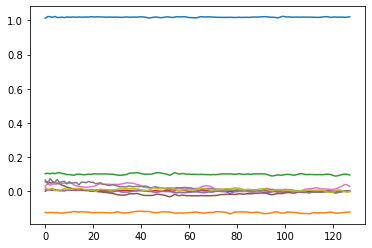

In [6]:
plt.plot(trainx[0])

In [7]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

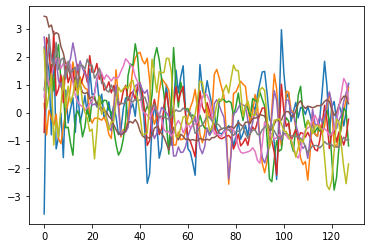

In [8]:
plt.plot(trainx[0])

In [9]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(7352, 1, 128, 9)
trainY shape:(7352, 6)
validX shape:(1473, 1, 128, 9)
validY shape:(1473, 6)
testX shape:(1474, 1, 128, 9)
testY shape:(1474, 6)


In [10]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 128
input_channel 9


# 2. Training condition 정의

In [11]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-5

In [12]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [13]:
from FCN import CNN_MC_dropout

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3

In [14]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

6


In [15]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [16]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 128, 9), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 128, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 128, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128), dtype=flo

# 4. Training

In [17]:
import time
import os

In [18]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_standardized_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

HAR_CNN_MCdropout_standardized_1e-05_16


In [19]:
from training import get_batch

In [20]:
keep_prob =1.0

In [21]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/1.ckpt
  training loss:	1.791735
  training acc:	0.833
  validation loss:	1.790819
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/2.ckpt
  training loss:	1.789358
  training acc:	0.833
  validation loss:	1.789209
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/3.ckpt
  training loss:	1.787176
  training acc:	0.833
  validation loss:	1.787727
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/27.ckpt
  training loss:	1.729708
  training acc:	0.833
  validation loss:	1.755399
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/28.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/28.ckpt
  training loss:	1.726201
  training acc:	0.833
  validation loss:	1.753456
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/29.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/29.ckpt
  training loss:	1.722549
  training acc:	0.833
  validation loss:	1.751434
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/30.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_stan

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/54.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/54.ckpt
  training loss:	1.589102
  training acc:	0.834
  validation loss:	1.678711
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/55.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/55.ckpt
  training loss:	1.582390
  training acc:	0.834
  validation loss:	1.675099
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/56.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/56.ckpt
  training loss:	1.575622
  training acc:	0.835
  validation loss:	1.671457
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardi

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/80.ckpt
  training loss:	1.408822
  training acc:	0.840
  validation loss:	1.582815
  validation acc:	0.836
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/81.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/81.ckpt
  training loss:	1.401977
  training acc:	0.841
  validation loss:	1.579161
  validation acc:	0.836
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/82.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/82.ckpt
  training loss:	1.395152
  training acc:	0.841
  validation loss:	1.575509
  validation acc:	0.836
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/83.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_stan

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/106.ckpt
  training loss:	1.236739
  training acc:	0.845
  validation loss:	1.488061
  validation acc:	0.838
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/107.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/107.ckpt
  training loss:	1.230425
  training acc:	0.845
  validation loss:	1.484477
  validation acc:	0.838
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/108.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/108.ckpt
  training loss:	1.224141
  training acc:	0.845
  validation loss:	1.480901
  validation acc:	0.838
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/109.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/132.ckpt
  training loss:	1.083223
  training acc:	0.866
  validation loss:	1.399220
  validation acc:	0.849
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/133.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/133.ckpt
  training loss:	1.077809
  training acc:	0.867
  validation loss:	1.396045
  validation acc:	0.849
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/134.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/134.ckpt
  training loss:	1.072436
  training acc:	0.868
  validation loss:	1.392894
  validation acc:	0.850
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/135.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/158.ckpt
  training loss:	0.956234
  training acc:	0.889
  validation loss:	1.324739
  validation acc:	0.861
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/159.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/159.ckpt
  training loss:	0.951950
  training acc:	0.890
  validation loss:	1.322219
  validation acc:	0.861
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/160.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/160.ckpt
  training loss:	0.947711
  training acc:	0.890
  validation loss:	1.319723
  validation acc:	0.861
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/161.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/184.ckpt
  training loss:	0.858760
  training acc:	0.903
  validation loss:	1.266941
  validation acc:	0.869
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/185.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/185.ckpt
  training loss:	0.855558
  training acc:	0.904
  validation loss:	1.265018
  validation acc:	0.869
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/186.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/186.ckpt
  training loss:	0.852394
  training acc:	0.904
  validation loss:	1.263112
  validation acc:	0.869
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/187.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/210.ckpt
  training loss:	0.786714
  training acc:	0.913
  validation loss:	1.222591
  validation acc:	0.873
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/211.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/211.ckpt
  training loss:	0.784358
  training acc:	0.913
  validation loss:	1.221093
  validation acc:	0.873
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/212.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/212.ckpt
  training loss:	0.782029
  training acc:	0.913
  validation loss:	1.219609
  validation acc:	0.873
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/213.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/236.ckpt
  training loss:	0.733281
  training acc:	0.918
  validation loss:	1.187590
  validation acc:	0.879
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/237.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/237.ckpt
  training loss:	0.731510
  training acc:	0.918
  validation loss:	1.186380
  validation acc:	0.879
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/238.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/238.ckpt
  training loss:	0.729757
  training acc:	0.919
  validation loss:	1.185177
  validation acc:	0.879
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/239.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/262.ckpt
  training loss:	0.692409
  training acc:	0.922
  validation loss:	1.158241
  validation acc:	0.880
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/263.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/263.ckpt
  training loss:	0.691022
  training acc:	0.922
  validation loss:	1.157178
  validation acc:	0.880
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/264.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/264.ckpt
  training loss:	0.689645
  training acc:	0.922
  validation loss:	1.156117
  validation acc:	0.881
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/265.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/288.ckpt
  training loss:	0.659598
  training acc:	0.924
  validation loss:	1.131536
  validation acc:	0.882
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/289.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/289.ckpt
  training loss:	0.658454
  training acc:	0.924
  validation loss:	1.130540
  validation acc:	0.882
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/290.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/290.ckpt
  training loss:	0.657317
  training acc:	0.924
  validation loss:	1.129542
  validation acc:	0.882
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/291.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/314.ckpt
  training loss:	0.632019
  training acc:	0.927
  validation loss:	1.105999
  validation acc:	0.883
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/315.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/315.ckpt
  training loss:	0.631039
  training acc:	0.927
  validation loss:	1.105037
  validation acc:	0.883
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/316.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/316.ckpt
  training loss:	0.630065
  training acc:	0.927
  validation loss:	1.104078
  validation acc:	0.883
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/317.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/340.ckpt
  training loss:	0.608130
  training acc:	0.928
  validation loss:	1.081378
  validation acc:	0.885
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/341.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/341.ckpt
  training loss:	0.607273
  training acc:	0.928
  validation loss:	1.080449
  validation acc:	0.885
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/342.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/342.ckpt
  training loss:	0.606420
  training acc:	0.928
  validation loss:	1.079521
  validation acc:	0.885
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/343.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/366.ckpt
  training loss:	0.587137
  training acc:	0.930
  validation loss:	1.057836
  validation acc:	0.886
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/367.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/367.ckpt
  training loss:	0.586381
  training acc:	0.930
  validation loss:	1.056953
  validation acc:	0.886
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/368.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/368.ckpt
  training loss:	0.585629
  training acc:	0.930
  validation loss:	1.056072
  validation acc:	0.886
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/369.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/392.ckpt
  training loss:	0.568572
  training acc:	0.932
  validation loss:	1.035609
  validation acc:	0.887
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/393.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/393.ckpt
  training loss:	0.567902
  training acc:	0.932
  validation loss:	1.034787
  validation acc:	0.887
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/394.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/394.ckpt
  training loss:	0.567234
  training acc:	0.932
  validation loss:	1.033964
  validation acc:	0.887
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/395.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/418.ckpt
  training loss:	0.552042
  training acc:	0.933
  validation loss:	1.014928
  validation acc:	0.888
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/419.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/419.ckpt
  training loss:	0.551443
  training acc:	0.933
  validation loss:	1.014165
  validation acc:	0.888
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/420.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/420.ckpt
  training loss:	0.550847
  training acc:	0.933
  validation loss:	1.013404
  validation acc:	0.888
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/421.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/444.ckpt
  training loss:	0.537280
  training acc:	0.934
  validation loss:	0.995844
  validation acc:	0.888
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/445.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/445.ckpt
  training loss:	0.536745
  training acc:	0.934
  validation loss:	0.995139
  validation acc:	0.889
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/446.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/446.ckpt
  training loss:	0.536212
  training acc:	0.934
  validation loss:	0.994437
  validation acc:	0.889
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/447.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/470.ckpt
  training loss:	0.524066
  training acc:	0.935
  validation loss:	0.978323
  validation acc:	0.891
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/471.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/471.ckpt
  training loss:	0.523585
  training acc:	0.935
  validation loss:	0.977678
  validation acc:	0.891
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/472.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/472.ckpt
  training loss:	0.523106
  training acc:	0.935
  validation loss:	0.977041
  validation acc:	0.891
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/473.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/496.ckpt
  training loss:	0.512203
  training acc:	0.936
  validation loss:	0.962316
  validation acc:	0.892
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/497.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/497.ckpt
  training loss:	0.511773
  training acc:	0.936
  validation loss:	0.961727
  validation acc:	0.893
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/498.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/498.ckpt
  training loss:	0.511344
  training acc:	0.936
  validation loss:	0.961141
  validation acc:	0.893
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/499.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropou

In [22]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [23]:
from visualization import plot_train_history

In [24]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/loss_graph.png
save ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/acc_graph.png


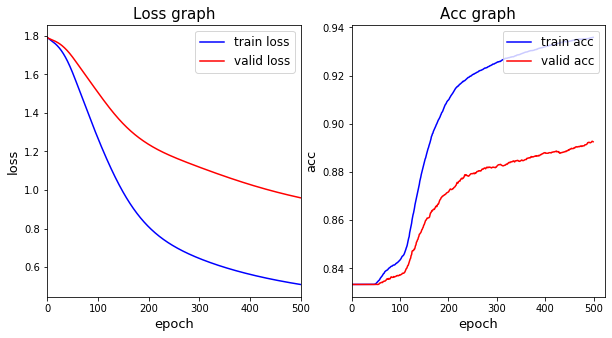

In [25]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [26]:
bestepoch = int(np.argmin(valid_history['loss']))

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [27]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.959972410316012


In [28]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/HAR/HAR_CNN_MCdropout_standardized_1e-05_16/499.ckpt
Model restored


### with confusion matrix

In [29]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [30]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

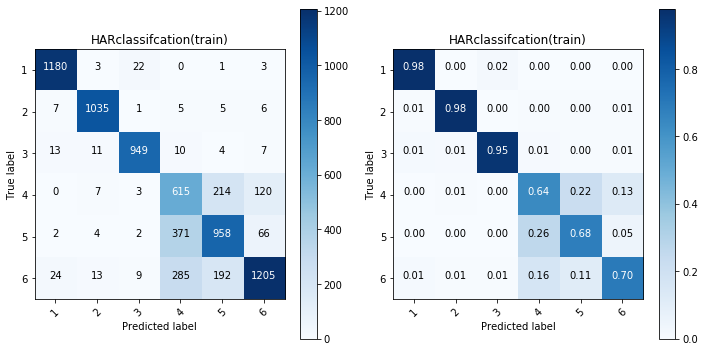

In [31]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

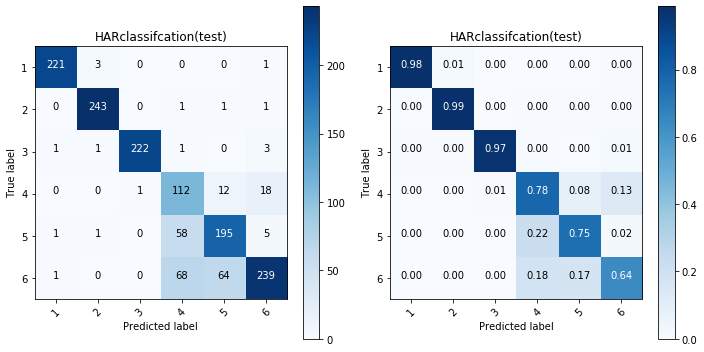

In [32]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
현재 p(A>T) = 0.05로 조정되어있음

In [33]:
import random

In [34]:
last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
print (last_conv_output.shape)
threshold = np.percentile(last_conv_output,99.5)
print ("threshold: {}".format(threshold))

(7352, 128, 128)
threshold: 7.261725971698802


In [35]:
last_conv_bool = last_conv_output>threshold

# 7.Result Visualization
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

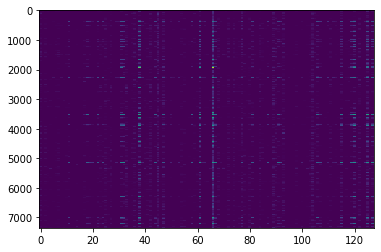

In [36]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

In [ ]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

## 패턴의 연속성 pattern candidate 추출(전체길이의 10퍼센트 이상이 highlight 된 부분)
## 현재 서버 메모리때문에 trainX 500개까지만 패턴 클러스터링 적용
### 모든 데이터를 위해서는 수정필요

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [ ]:
from itertools import groupby
from operator import itemgetter

In [ ]:
consecutive_num =trainX.shape[2]//20
consecutive_num

In [ ]:
import itertools

In [ ]:
input_channel = 3
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500,:,:,[input_channel]]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":g, "pattern":data[0,g,c], "pattern_channel":output_channel_idx})   

해당 길이 이상의 패턴들을 window slicing 하여 자르는 방법을 이용하실 경우,
밑에 코드를 활성화 하시고, 위에 코드를 주석 처리하시면 됩니다.

input_channel = 3
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:200,:,:,[input_channel]]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        for start_idx in range(0,len(g)-consecutive_num+1,step_size):
                            short_pattern_idx = [g[x] for x in range(start_idx, start_idx+consecutive_num)]
                            consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":short_pattern_idx, "pattern":data[0,short_pattern_idx,c], "pattern_channel":output_channel_idx}) 

In [ ]:
pattern = [x['pattern'] for x in consecutive_pattern]

In [ ]:
l_pattern=[]
for l in np.unique([len(x) for x in pattern_candidate]):
    l_pattern.append(len([x for x in pattern_candidate if len(x)==l]))

In [ ]:
l_pattern_dict=dict()
for i,l in enumerate(l_pattern):
    l_pattern_dict[str(np.unique([len(x) for x in pattern_candidate])[i])]=l

# clustering

In [ ]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
n_clusters = 5

## clustering with different length scale

#### Global Alignmnet Kernel K Means

In [ ]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import GlobalAlignmentKernelKMeans

In [ ]:
#길이를 맞추기위해 nan으로 패딩
X =to_time_series_dataset(pattern)

In [ ]:
gak_km = GlobalAlignmentKernelKMeans(n_clusters=n_clusters)
gak_km_predict = gak_km.fit_predict(X)

class_breakdown(gak_km_predict)

In [ ]:
for n in range(n_clusters):
    idx = [i for i,x in enumerate(gak_km_predict) if x==n]
    vars()["pattern_"+str(n)] = [pattern[i] for i in idx ]

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    for p in eval("pattern_"+str(n)):
        ax.plot(range(len(p)),p,color = color[n])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    mindexes = [np.argmax(x) for x in eval("pattern_"+str(n))]
    vars()["norm_pattern_"+str(n)] = [(x-min(x)) for x in eval("pattern_"+str(n))]
    for i,p in enumerate(eval("norm_pattern_"+str(n))):
        shifts = max(mindexes) - mindexes[i]
        ax.plot(range(shifts,shifts+len(p)), p,color=color[n],alpha=0.2)

        #plt.plot(range(len(p)), p)
        #break
plt.show()

### find representative shape for each clustering

#### 1. Using U shapelet
ref: Clustering Time Series using Unsupervised-Shapelets

In [ ]:
len(pattern)

In [ ]:
import copy
sLen = range(5,9)
D=copy.deepcopy(pattern)

In [ ]:
S_hat=[]
ts=D[50]
for _ in range(10):
    cnt=0 #count of candidate u-shapelets from ts
    s_hat ={} #set of subsequences, initially empty
    gap = []
    dt =[]
        
    for sl in sLen:#each u-shapelet length
        for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
            s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
            tup = compute_gap(s_hat[cnt],D,6)
            gap.append(tup[0])
            dt.append(tup[1])
            cnt+=1
    if cnt>0:
        index1 = np.argmax(gap)
        S_hat.append(s_hat[index1]) #find maximum gap score
        dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score
        try:
            dA= [dis[i] for i,x in enumerate(dis<dt[index1]) if x==True] #points to the left of dt
        except:
            dA = [dis[i] for i,x in enumerate(dis) if x<dt[0]]

        if len(dA) ==1:
            print("dA length:1")
            break
        else:
            index2 = np.argmax(dis)
            ts = D[index2]
            msdA= np.mean(dA) +np.std(dA)
            D_hat = [i for i,x in enumerate(dis<msdA) if x ==True]
            idx = [x for x in np.arange(0,len(D)) if x not in D_hat]
            new_D=[]
            for d_idx in idx:
                new_D.append(D[d_idx])
            D=new_D

In [ ]:
def znorm(data):
    return (data-min(data))/(max(data)-min(data))

In [ ]:
def euclidean_d(data1,data2):
    return np.linalg.norm(data1-data2)

In [ ]:
def compute_gap(sub, data,cluster_num):
    dis= compute_distance(sub,data)
    dis = np.sort(dis)
    maxGap = 0
    dt = 0
    for l in range(1, len(dis)-1):
        d = (dis[l]+dis[l+1])/2

        dA = dis[dis<d]
        dB = dis[dis>d]
        try:
            r = len(dA)/len(dB)
            if ((1/cluster_num < r) and (1-(1/cluster_num))):
                mA = dA.mean()
                mB = dB.mean()
                sA = dA.std()
                sB = dB.std()
                gap = mB-sB-(mA+sA)
                if gap > maxGap :
                    #print("gap {}".format(gap))
                    maxGap =gap
                    dt =d
        except:
            pass
    return maxGap, dt

In [ ]:
def compute_distance(sub, data):
    dis=[10e3]*len(data)
    sub = znorm(sub)
    for i in range(0,len(data)):
        ts = data[i]

        for j in range(0, len(ts)-len(sub)):
            z = znorm(ts[j:j+len(sub)])
            d = euclidean_d(z,sub)
            dis[i]= min(d,dis[i])/np.sqrt(len(sub))
        #print(dis[i])
    return dis

#### 2. Use dtw measure

In [ ]:
from dtwalign import dtw

In [ ]:
x = norm_pattern_5[60]
y = norm_pattern_5[0]
res = dtw(x,y)

# dtw distance
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

"""
if you want to calculate only dtw distance (i.e. no need to gain alignment path),
give 'distance_only' argument as True (it makes faster).
"""
#res = dtw(x,y,distance_only=True)

In [ ]:

ax = plt.subplot(2,1,1)
ax.plot(x,color="blue")
ax.plot(y,color="red")
ax.set_ylim(0,1)
# warp both x and y by alignment path
x_path = res.path[:,0]
y_path = res.path[:,1]

ax = plt.subplot(2,1,2)
ax.plot(x[x_path],label="aligned query",color="blue")
ax.plot(y[y_path],label="aligned reference",color="red")
ax.legend()
ax.set_ylim(0,1)

# visualize alignment path with cumsum cost matrix
res.plot_path()

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_info = [consecutive_pattern[x] for x in specific_data_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==5:
        break
    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']== p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_data_pattern_idx[idx]
            color_idx = gak_km_predict[specific_data_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,consecutive_pattern[pattern_idx]['pattern_channel']))
        break

        
    plt.show()

l_pattern_dict :패턴의 길이와 해당 길이의 패턴의 수를 매칭시켜놓은 변수

# clustering for pattern_candidate

1. 패턴의 길이를 fix하고 해당 length의 패턴만을 클러스터링

In [ ]:
pattern_len = 5
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if len(x['pattern_idx']) ==pattern_len]

In [ ]:
pattern_candidate =  np.asarray([consecutive_pattern[idx]['pattern'] for idx in specific_len_pattern_idx])
len(pattern_candidate)

## pattern standardization

1. pattern 원본 그대로 사용
2. 평균0, 분산1 형태로 standardization
3. 각 패턴이 0~1 사이로 min,max normalization 

1,2,3 방법 혹은 어떤 방법으로 정규화 할지를 같이 정하면 될것 같습니다.
저는 우선 2번,3번 방법으로 진행해보았습

#1. pattern 원본 그대로 사용
normalized_pattern_candidate =l_pattern_candidate

#2. 평균0, 분산1 형태로 standardization
from sklearn.preprocessing import StandardScaler
normalized_pattern_candidate =StandardScaler().fit_transform(np.asarray(l_pattern_candidate))

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform(pattern_candidate)
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

In [ ]:
normalized_pattern_candidate = pattern_candidate

#3.각 패턴이 0~1 사이로 min,max normalization
normalized_pattern_candidate = (l_pattern_candidate.T - l_pattern_candidate.min(axis=1))/(l_pattern_candidate.max(axis=1)- l_pattern_candidate.min(axis=1))
normalized_pattern_candidate = normalized_pattern_candidate.T

## spectral clustering, gmm clustering,k-means,SOM

In [ ]:
from sklearn import mixture,cluster
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’
default_spectral = {'n_clusters':2,
                    'eigen_solver': 'arpack',
                    'affinity': "rbf"}

#covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}
default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

spectral_option = [
    ({'n_clusters': 6})
]

gmm_option = [
    ({'n_clusters': 6})
    
]

kmeans_option = [
    ({'n_clusters': 6})
    
]

hac_option =[
    ({'cut_off_level': 6})
    
]

parameter 조절하며 시각화

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

In [ ]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for g_option,k_option in zip(gmm_option,kmeans_option):

    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)
    
    g_cluster_mean_pattern =[]
    k_cluster_mean_pattern =[]

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,7))
    axes = fig.subplots(2, g_params['n_clusters'])
    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]

        try:
            axes[0,class_].plot(normalized_pattern_candidate[random.sample(g_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[random.sample(k_class_idx,30)].T, color =color[class_],alpha=0.6)

        except:
            axes[0,class_].plot(normalized_pattern_candidate[g_class_idx].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[k_class_idx].T, color =color[class_],alpha=0.6)

        g_cluster_mean = normalized_pattern_candidate[g_class_idx].mean(axis=0)
        g_cluster_mean_pattern.append(g_cluster_mean)
        k_cluster_mean = normalized_pattern_candidate[k_class_idx].mean(axis=0)
        k_cluster_mean_pattern.append(k_cluster_mean)
        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)

    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()

In [ ]:
import more_itertools as mit
from sklearn.preprocessing import MinMaxScaler

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_idx= list(set(specific_data_pattern_idx) & set(specific_len_pattern_idx))
    specific_pattern_info = [consecutive_pattern[x] for x in specific_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==9:
        break

    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']==p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_pattern_idx[idx]
            color_idx = g_pred[specific_len_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])


            # 패턴의 평균값 굵고 투명하게 그리기
            x = g_cluster_mean_pattern[color_idx].reshape(-1,1) #returns a numpy array
            min_max_scaler = MinMaxScaler(feature_range=(data[pattern_x].min(), data[pattern_x].max()))
            x_scaled = min_max_scaler.fit_transform(x)
            ax.plot(pattern_x, x_scaled, color = color[color_idx], alpha=0.4,linewidth=10)
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,consecutive_pattern[pattern_idx]['pattern_channel']))
    plt.show()

# Below part is still unclear

f = open('file.txt', 'a+t')
for i,x in enumerate(X):
    for x_ in x:
        f.write(str(x_[0])+",")
    f.write(":"+str(gak_km_predict[i])+"\n")

f.close()      

In [ ]:
X_df = pd.DataFrame(columns=["dim_0"],index=range(len(X)))
for i,x in enumerate(X):
    X_df.iloc[i,0] = x

In [ ]:
Y_df =gak_km_predict.astype('<U1')

In [ ]:
from sktime.transformers.shapelets import ContractedShapeletTransform
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_limit_in_mins = 1

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
initial_num_shapelets_per_case = 5

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_limit_in_mins=time_limit_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(X_df, Y_df)

In [ ]:
# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(
        X[s.series_id],
        'gray'
    )

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        X[s.series_id,s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

## hierarchical clustering

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

D = hac.linkage(normalized_pattern_candidate[:20], method='single',metric='euclidean')
cut_off_level = 5
#Dendrogram
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
plt.xlabel('sample index', fontsize=25, fontweight='bold')
plt.ylabel('distance', fontsize=25, fontweight='bold')
hac.dendrogram(D, leaf_rotation=90., leaf_font_size=15., ) # font size for the x axis labels
plt.show()

특정 파라미터에 해당하는 클러스터 시각화

In [ ]:
import matplotlib.patheffects as pe

In [ ]:
random.seed(300)
sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),len(normalized_pattern_candidate))
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
for s_option,g_option,k_option in zip(spectral_option[::-1],gmm_option[::-1],kmeans_option[::-1]):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    spectral.fit(normalized_pattern_candidate)
    gmm.fit(normalized_pattern_candidate)
    kmeans.fit(normalized_pattern_candidate)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    k_pred = kmeans.fit_predict(normalized_pattern_candidate[sample_data_idx])
    
    num_class = len(list(set(np.unique(s_pred)).union(set(np.unique(g_pred)))))
    fig = plt.figure(figsize=(18,5))
    axes = fig.subplots(3,num_class)    
    
    for class_ in range(0,num_class):
        class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        try:
            axes[0][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[0][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color = 'black',alpha=1,linewidth=3,
                   path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        
        class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        try:
            axes[1][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[1][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        try:
            axes[2][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[2][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()
    break

# SOM

In [ ]:
import sompy

In [ ]:
som = sompy.SOMFactory.build(normalized_pattern_candidate, mapsize=None, normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose=False)  # verbose='debug' will print more, and verbose=None wont print anything

In [ ]:
from sompy.visualization.hitmap import HitMapView
som.cluster(4)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(som)

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim="all", desnormalize=True)

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

## represent as feature vector

### 1. wavelet

In [ ]:
import do_wavelet
import matplotlib.gridspec as gridspec
import pywt

In [ ]:
N = normalized_pattern_candidate[3].shape[0]
t0=10
dt=1
time = np.arange(0, N) * dt + t0
signal = normalized_pattern_candidate[3]
 
scales = np.arange(1, 128)

In [ ]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[:2, 0:5])
bottom_left_ax = fig.add_subplot(spec[2:, 0:5])
bottom_right_ax = fig.add_subplot(spec[2:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

### 2. clustering time series using unsupervised shapelets

In [ ]:
D =pattern.copy(deep=True)
sLen = range(6,32)

S_hat={}
ts =D[500]

In [ ]:
len(pattern)

In [ ]:
s_option =spectral_option[-1]
g_option=gmm_option[-1]
s_params = default_spectral.copy()
s_params.update(s_option)

g_params = default_gmm.copy()
g_params.update(g_option)

spectral = cluster.SpectralClustering(
    n_clusters=s_params['n_clusters'], 
    eigen_solver=s_params['eigen_solver'],
    affinity=s_params['affinity'])

gmm =  mixture.GaussianMixture(
    n_components=g_params['n_clusters'], 
    covariance_type=g_params['covariance_type'])

s_pred = spectral.fit_predict(normalized_pattern_candidate)
g_pred = gmm.fit_predict(normalized_pattern_candidate)

s_representative_pattern =[]
g_representative_pattern =[]
for class_ in np.unique(s_pred):

    s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
    s_representative_pattern.append(normalized_pattern_candidate[s_class_idx].mean(axis=0))

    g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
    g_representative_pattern.append(normalized_pattern_candidate[g_class_idx].mean(axis=0))


In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 2, 1,projection='3d')

x = ((g_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((g_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((g_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax.scatter(x,y,z, c = g_pred)

ax.set_xlabel('class1')
ax.set_ylabel('class2')
ax.set_zlabel('class3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.axis('off')

ax2 = fig.add_subplot(1, 2, 2,projection='3d')

x = ((s_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((s_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((s_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax2.scatter(x,y,z, c = s_pred)

ax2.set_xlabel('class1')
ax2.set_ylabel('class2')
ax2.set_zlabel('class3')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option in zip(spectral_option,gmm_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    s_pred = spectral.fit(normalized_pattern_candidate)
    g_pred = gmm.fit(normalized_pattern_candidate)
    
    sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),100)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    
    fig = plt.figure(figsize=(15,3))
    for class_ in np.unique(s_pred):
        ax = plt.subplot(1,2,1)
        class_idx = [sample_data_idx[i] for i,x in enumerate(s_pred) if x ==class_]
        ax.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
        ax.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)

        ax2 = plt.subplot(1,2,2)
        class_idx = [sample_data_idx[i] for i,x in enumerate(g_pred) if x ==class_]
        try:
            #ax2.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
            ax2.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)
        except:
            continue

    fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params))
    plt.tight_layout()


### plotly visualization을 위해 샘플 데이터 및 패턴 저장

In [ ]:
sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

In [ ]:
sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

In [ ]:
last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

In [ ]:
groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

In [ ]:
consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

In [ ]:
sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

## 2d visualization

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

## 3d visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%matplotlib qt

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                #ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.2, 1]))
    break